# Known issues

## A float quantity is Iterable
https://docs.python.org/3/library/collections.abc.html#collections.abc.Iterable
This tests if the object has "__iter__"

In [1]:
import collections
from physipy import m

isinstance(m, collections.abc.Iterable)

True

## Array repr with 0 value
Pick best favunit take the smallest when 0 is in the array with positiv and negativ values

In [2]:
from physipy import m, Quantity, Dimension
import numpy as np
Quantity(np.array([0, -1.2, 1.2]), Dimension("L"))

<Quantity : [ 0.  -1.2  1.2] m>

# Inplace change using asqarray

In [10]:
from physipy.quantity.utils import asqarray
print(type(m.value))
arrq_9 = np.array([m.__copy__()], dtype=object)
out = asqarray(arrq_9)
# this changes the type of m value
print(type(m.value))

<class 'int'>
<class 'int'>


# Numpy trapz implementaion not called when only x or dx is a quantity

https://github.com/numpy/numpy/issues/18902

Only work when the array to integrate is a quantity

In [1]:
from physipy import m
import numpy as np

In [13]:
# this works
print(np.trapz(np.arange(5)*m))
# also this
print(np.trapz(np.arange(5), x=np.arange(5)*m))
print(np.trapz(np.arange(5), dx=5000*m, x=np.arange(5)*m)) #dx is silent
# but not this
#np.trapz(np.arange(5), dx=5000*m)
print("----uncomment above line to trigger exception")

into array function
8.0 m
into array function
8.0 m
into array function
8.0 m
----uncomment above line to trigger exception


# Array function interface not triggered on scalars

Calling a numpy function with only scalars will not trigger the array function interface, since it is used only when an argument is an array.

In [15]:
from physipy import m
# this raises a DimensionError because of the casting into float
#np.random.normal(3*m, 1*m)
# while this works
np.random.normal(np.array(3*m), np.array(1*m))

2.4153630235574304

# FIXED (Matplotlib histogram) by adding "to_numpy" method

Some preprocessing turn a quantity-array into a "set of elements", and plots one histogram for each value.

In [1]:
import numpy as np
from physipy import m
import matplotlib.pyplot as plt

In [2]:
arr = np.random.normal(1, 0.1, size=100)*m

(array([ 9.,  9., 16., 20., 17., 14.,  5.,  4.,  4.,  2.]),
 array([0.80637867, 0.85745141, 0.90852415, 0.9595969 , 1.01066964,
        1.06174238, 1.11281512, 1.16388786, 1.21496061, 1.26603335,
        1.31710609]),
 <BarContainer object of 10 artists>)

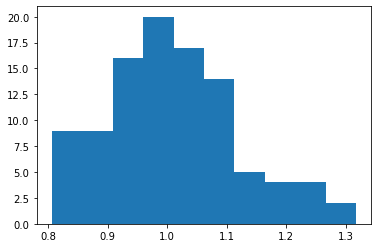

In [3]:
plt.hist(arr.value)

(array([ 9.,  9., 16., 20., 17., 14.,  5.,  4.,  4.,  2.]),
 array([0.80637867, 0.85745141, 0.90852415, 0.9595969 , 1.01066964,
        1.06174238, 1.11281512, 1.16388786, 1.21496061, 1.26603335,
        1.31710609]),
 <BarContainer object of 10 artists>)

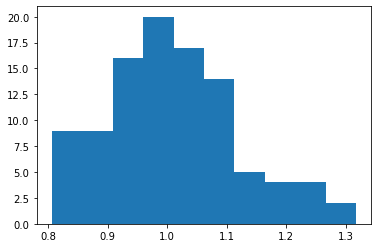

In [4]:
plt.hist(arr)